# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by Chibueze Louis Alagbogu

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find locations in **Downtown Toronto** similar to **ParkWoods**. One of the most popular venue in Parkwoods is KFC, if KFC wishes to replicate their success from ParkWoods in Downtown Toronto, this project would be very much helpful. It can also be used by residents moving from Parkland and wish to be in a similar neighborhood in Downtown Toronto.

We will use our data science powers to generate similar and disimilar neighborhoods to guide the stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, the major factor that will influence our decision are the types of venues in each neighborhood


Following data sources will be needed to extract/generate the required information:
* List of Postal Codes in Canada gotten from the [wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
* CSV file containing Canadas [Geospatial coordinates](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv)
* Types of venues in every neighborhood in Downtown Toronto will be obtained using **Foursquare API**
* Geographical coordinate of Downtown Toronto will be obtained using **Geocoder** 

**Importing necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**Scrapping and Wrangling the data of Toronto Neighborhoods**

Scrapping the Wikipedia webpage using BeautifulSoup to extract data such as:
* Postal Code
* Borough and
* Neighborhood
of the various cities in Canada.

In [2]:
url= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data= requests.get(url).text
data= BeautifulSoup(data, "lxml")
table=data.find('table')
table_contents= []
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


**Reading Geospatial Coordinates CSV file with Watson Studio**

The geographical coordinates of the neighborhoods containing each postal code was gotten from a csv file downloaded through this [link.](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv)

Reading CSV files on IBM Watson Studio is a bit different, as it requires my storage details and other sensitive details, the cell would be hidden.

In [3]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Merging the data to add Latitude and Longitude to the Data Frame**

The geospatial data containing the postal codes contains just three(3) columns:
* Postal Code
* Latitude
* Longitude

So the data would be merged with the one gotten after scrapping the wikipedia page, the criteria for merging both data would be the Postal Code.

In [4]:
df_geo.rename(columns={"Postal Code": "PostalCode"}, inplace= True)
toronto_data = pd.merge(df, df_geo, how="left", on="PostalCode")
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


*In line with our objective, the data from Parkwood neighborhood and Downtown Toronto borough would be separated and each would have their own individual dataframes*

In [5]:
pw_data= toronto_data[toronto_data["Neighborhood"]=="Parkwoods"].reset_index(drop= True)
pw_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656


In [6]:
dt_data= toronto_data[toronto_data["Borough"]=="Downtown Toronto"].reset_index(drop= True)
dt_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817


*Using Geocoder to get the coordinate of Downtown Toronto*

In [7]:
address = 'Downtown Toronto'

geolocator = Nominatim(user_agent="dt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081162653639.


**Visualizing the Map of Downtown Toronto**

Blue markers would be added to show the neighborhoods in Downtown Toronto and a green marker to show Parkland neighborhood

In [8]:
# create map of Downtown Toronto using latitude and longitude values
map_dt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dt_data['Latitude'], dt_data['Longitude'], dt_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dt)  

# adding parkland neighborhood marker
folium.CircleMarker(
    [pw_data["Latitude"], pw_data["Longitude"]],
    radius= 5,
    popup= pw_data['Neighborhood'],
    color= 'green',
    fill= True,
    fill_color= '#3186cc',
    fill_opacity= 0.7,
    parse_html= False).add_to(map_dt)
map_dt

**FourSquare API**

Now that we have our location candidates, let's use Foursquare API to get info on venues in each neighborhood.

Since the codes contain my Foursquare Client ID and other sensitive information, the cells would be hidden.

In [9]:
# The code was removed by Watson Studio for sharing.

Your FourSquare credentails:
CLIENT_ID: ****************************
CLIENT_SECRET:****************************


*Defining a function that gets nearby venues using the FourSquare API and using it to get venues around Parkwoods neighborhood and other neighborhoods in Downtown Toronto*

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
dt_venues = getNearbyVenues(names=dt_data['Neighborhood'],
                                   latitudes=dt_data['Latitude'],
                                   longitudes=dt_data['Longitude']
                                  )

In [12]:
print(dt_venues.shape)
dt_venues.head()

(454, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [13]:
pw_venues = getNearbyVenues(names=pw_data['Neighborhood'],
                                   latitudes=pw_data['Latitude'],
                                   longitudes=pw_data['Longitude']
                                  )

In [14]:
print(pw_venues.shape)
pw_venues.head()

(4, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping


In [15]:
pwdt_venues= pw_venues.append(dt_venues, ignore_index= True)
print(pwdt_venues.shape)
pwdt_venues.head()

(458, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Parkwoods,43.753259,-79.329656,Corrosion Service Company Limited,43.752432,-79.334661,Construction & Landscaping
4,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop


**One Hot Encoding**

Now one hot encoding is used to convert all the different venue categories from strings to real numbers. One(1) and zero(0) is used to represent the availability of a venue category. If a venue category exists in a neighborhood, it is represented by one(1) and if it doesn't, it is represented by zero(0).

Converting the data to numerical values would make analysis easier along the line.

In [16]:
# one hot encoding
pwdt_onehot = pd.get_dummies(pwdt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pwdt_onehot['Neighborhood'] = pwdt_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = pwdt_onehot.columns.tolist()
cols= cols[100:101] + cols[0:100] + cols[101:]
pwdt_onehot = pwdt_onehot[cols]

pwdt_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Distribution Center,Donut Shop,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Lake,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Skating Rink,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Grouping the Data**

Now the data would be grouped with respect to the different neighborhoods by taking the mean of the venue categories.

In [17]:
pwdt_grouped = pwdt_onehot.groupby('Neighborhood').mean().reset_index()
pwdt_grouped.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Distribution Center,Donut Shop,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,Gluten-free Restaurant,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Lake,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Park,Performing Arts Venue,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Skating Rink,Spa,Speakeasy,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.033333,0.066667,0.000000,0.0,0.033333,0.066667,0.0,0.0,0.033333,0.000000,0.000000,0.033333,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.033333,0.0,0.0,0.0,0.066667,0.033333,0.0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.033333,0.0,0.000000,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.033333,0.0,0.000000,0.0000,0.0,0.0,0.0,0.033333,0.0,0.033333,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.033333,0.000000,0.0,0.000000,0.0,0.000000,0.066667,0.0,0.0,0.0,0.033333,0.000000,0.0,0.000000,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.071429,0.071429,0.071429,0.142857,0.142857,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0000,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.071429,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.071429,0.000000,0.000000,0.0,0.000000,0.0,0.071429,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,Central Bay Street,0.000000,0.000000,0.000000,0

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas in Downtown Toronto that are similar to the Parkwoods Neighborhood.

In first step we have collected the required data:
* List of Postal Codes in Canada gotten from the [wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
* CSV file containing Canadas [Geospatial coordinates](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv)
* Types of venues in every neighborhood in Downtown Toronto will be obtained using **Foursquare API**
* Geographical coordinate of Downtown Toronto will be obtained using **Geocoder** 


We have also grouped the data by venue category (according to Foursquare categorization) and applied One hot encoding.

The final step we will focus on creating clusters of neighborhoods in Downtown Toronto and Parkwoods neighborhood using **k-means clustering**. The neighborhoods in Downtown Toronto that are similar to Parkwoods neighborhood would be clustered together.

**Optimal Value of K**

In order to choose an optimal value of K, we used the Elbow method.

In this method, the sum of square errors is plotted against the different values of K and the value that has the most critical bend is chosen as the optimal value.

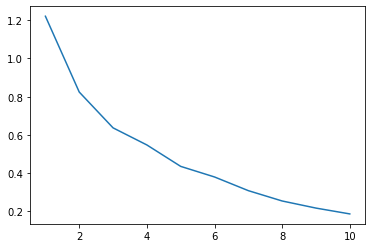

In [18]:
pwdt_grouped_clustering = pwdt_grouped.drop('Neighborhood', 1)
# set number of clusters
ks= 11
SE= []
for k in range(1,ks):
    kclusters = k
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pwdt_grouped_clustering)
    SE.append(kmeans.inertia_)
plt.plot(range(1, 11), SE)

From the plot, the optimal value of K is 3. So we use K=3 for our k-means clustering

In [19]:
kclusters= 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(pwdt_grouped_clustering)


**Merging the Cluster Label to Dataframe**

After merging the cluster label to the dataframe, we check for the label of Parkwoods and then view all the neighborhoods containing similar labels and also, the neighborhoods containing dissimilar labels.

In [20]:
pwdt_data= pw_data.append(dt_data, ignore_index= True)
pwdt_data["Cluster Labels"]= kmeans.labels_
final_df= pwdt_data[pwdt_data["Cluster Labels"]==0]
final_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,0
1,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,0
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0


In [21]:
final2_df= pwdt_data[pwdt_data["Cluster Labels"]>0]
final2_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
10,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,1
13,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2


Using the map to **visualize the locations of the neighborhood in downtown toronto similar to Parkwoods neighborhood**

The Blue marker represents the similar neighborhoods in Downtown toronto and the red marker represents dissimilar neighborhoods while the green marker represents Parkwoods neighborhood

In [22]:
dt= final_df[1:]
map_f = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dt['Latitude'], dt['Longitude'], dt['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_f)  

folium.CircleMarker(
    [pw_data["Latitude"], pw_data["Longitude"]],
    radius= 5,
    popup= pw_data['Neighborhood'],
    color= 'green',
    fill= True,
    fill_color= '#3186cc',
    fill_opacity= 0.7,
    parse_html= False).add_to(map_f)

for lat, lng, label in zip(final2_df['Latitude'], final2_df['Longitude'], final2_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_f)

map_f

## Results<a name="results"></a>

Our analysis shows that although there is a great number of neighborhoods in Downtown Toronto which is similar to Parkwoods neighborhood. Only two(2) neighborhoods are different, which are:
* Commerce court, Victoria Hotel and
* CN Tower, King and Spadina, Railway Lands

It is also important to note that from our result, even though these neighborhoods stated above are dissimilar to Parkwoods neighborhood, they are also dissimilar to themselves. Those neighborhoods are **NOT** similar.



## Discussion<a name="discussion"></a>

Purpose of this project was to identify neighborhoods in Downtown Toronto that are similar to Parkwoods Neighborhood. So if one is moving from Parkwoods to Downtown Toronto and is curious to stay in a similar or dissimilar neighborhood from Parkwoods using Nearby venues as the criteria. Neighborhoods in Downtown Toronto are all similar to Parkwoods bar Commerce court, Victoria hotel, CN Tower, King and Spadina and Railway Lands.

## Conclusion<a name="conclusion"></a>

Purpose of this project was to identify neighborhoods in Downtown Toronto that are similar to Parkwoods Neighborhood. So if one is moving from Parkwoods to Downtown Toronto and is curious to stay in a similar or dissimilar neighborhood from Parkwoods using Nearby venues as the criteria. Neighborhoods in Downtown Toronto are all similar to Parkwoods bar Commerce court, Victoria hotel, CN Tower, King and Spadina and Railway Lands.

Final decision should be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.